In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection as sms 


def read_data(name):
    df = pd.read_csv(name)
    X = df.loc[:, df.columns != 'target']
    y = df.loc[:, 'target'].values
    X_train, X_tv, y_train, y_tv = sms.train_test_split(X, y, train_size=0.8, random_state = 42, shuffle=True)
    X_test, X_val, y_test, y_val = sms.train_test_split(X_tv, y_tv, train_size=0.5, random_state = 42, shuffle=True)
    return df, (X_train, y_train), (X_test, y_test), (X_val, y_val)

df, train, test, val = read_data('data/st_filt_data.csv')
print(sum(train[1]), len(train[1]))
print(sum(test[1]), len(test[1]))
print(sum(val[1]), len(val[1]))

368 800
50 100
49 101


* random forrest
* svm

In [2]:
from sklearn import ensemble as ske
rf = ske.RandomForestClassifier(n_estimators=100, min_samples_split=16, random_state=42, bootstrap=True,
                                 n_jobs=-1, oob_score=True)
rf.fit(train[0], train[1])

RandomForestClassifier(min_samples_split=16, n_jobs=-1, oob_score=True,
                       random_state=42)

In [3]:
from sklearn import metrics as skm

train_pred = rf.predict(train[0])
test_pred = rf.predict(test[0])

print(skm.confusion_matrix(train[1], train_pred))
print(skm.confusion_matrix(test[1], test_pred))

print(rf.score(test[0], test[1]))
print(rf.score(train[0], train[1]))

[[407  25]
 [ 24 344]]
[[44  6]
 [ 2 48]]
0.92
0.93875


In [4]:
from sklearn import tree

tree_accuracy=[]
for tree_nr in range(0,100):
    tree_accuracy.append(skm.accuracy_score(train[1], rf.estimators_[tree_nr].predict(train[0])))
best_tree = tree_accuracy.index(max(tree_accuracy))

fn=df.columns.tolist()
cn=['Normal', 'Disease']
fig = plt.figure(figsize=(30,40), dpi=800)
_ = tree.plot_tree(rf.estimators_[best_tree],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [5]:
from sklearn import svm as sks

for i in ['rbf', 'sigmoid']:
    for j in ['auto', 'scale']:
        svm = sks.SVC(kernel=i, gamma=j, class_weight='balanced', random_state=42)
        svm.fit(train[0], train[1])

        train_pred = svm.predict(train[0])
        test_pred = svm.predict(test[0])
        
        print('config:',i,j)
        
        print(skm.confusion_matrix(train[1], train_pred))
        print(skm.confusion_matrix(test[1], test_pred))

        print(svm.score(test[0], test[1]))
        print(svm.score(train[0], train[1]))
        
        print('\n\n\n')
        
        if i in ['linear', 'precomputed']:break

config: rbf auto
[[395  37]
 [ 25 343]]
[[43  7]
 [ 7 43]]
0.86
0.9225




config: rbf scale
[[301 131]
 [ 86 282]]
[[39 11]
 [ 8 42]]
0.81
0.72875




config: sigmoid auto
[[432   0]
 [368   0]]
[[50  0]
 [50  0]]
0.5
0.54




config: sigmoid scale
[[170 262]
 [246 122]]
[[20 30]
 [28 22]]
0.42
0.365






In [6]:
svm = sks.SVC(kernel='rbf', gamma='auto', class_weight='balanced', random_state=42, probability=True)
svm.fit(train[0], train[1])

print(skm.confusion_matrix(train[1], train_pred))
print(skm.confusion_matrix(test[1], test_pred))

print(svm.score(test[0], test[1]))
print(svm.score(train[0], train[1]))

[[170 262]
 [246 122]]
[[20 30]
 [28 22]]
0.86
0.9225


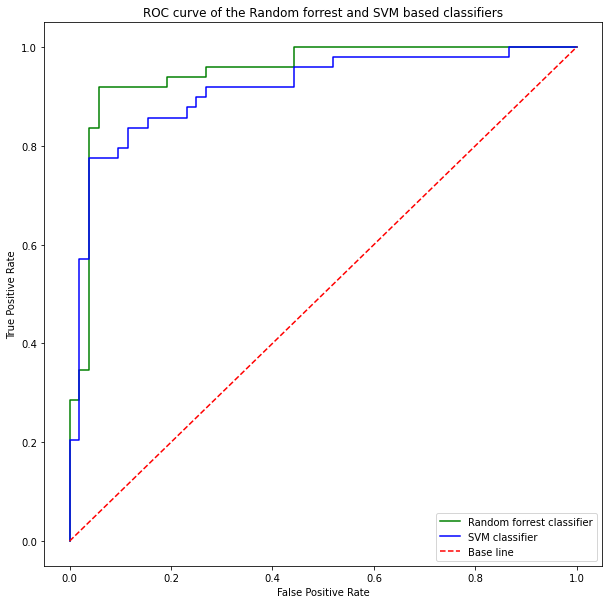

random forrest
[[49  3]
 [ 4 45]]
recal: 0.92
precision: 0.94
F1: 0.93
accuracy: 0.93
error: 0.07


Support vector machine
[[46  6]
 [ 9 40]]
recal: 0.84
precision: 0.88
F1: 0.86
accuracy: 0.85
error: 0.15




In [7]:
import seaborn as sns

pred_rf = rf.predict_proba(val[0])
pred_rf = [x[1] for x in pred_rf]

pred_svm = svm.predict_proba(val[0])
pred_svm = [x[1] for x in pred_svm]

fpr_rf, tpr_rf, thresholds = skm.roc_curve(val[1], pred_rf)
fpr_svm, tpr_svm, thresholds = skm.roc_curve(val[1], pred_svm)


fig = plt.figure(figsize=(10,10))
plt.plot(fpr_rf, tpr_rf, color='green', label='Random forrest classifier')
plt.plot(fpr_svm, tpr_svm, color='blue', label='SVM classifier')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Base line')
plt.legend()

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of the Random forrest and SVM based classifiers')
plt.legend()
plt.show(block=False)

def confusion(classifier, data, cln):
    pred = classifier.predict(data[0])
    conf = skm.confusion_matrix(data[1], pred)

    print(cln)
    print(conf)
    rec = conf[0][0]/(conf[0][0] + conf[1][0])
    pre = conf[0][0]/(conf[0][0] + conf[0][1])
    acc = (conf[0][0] + conf[1][1])/(conf[0][0] + conf[0][1] + conf[1][0] + conf[1][1])
    
    print('recal:', round(rec,2))
    print('precision:', round(pre,2))
    print('F1:', round(2*(rec*pre)/(rec+pre),2))
    print('accuracy:',round(acc,2))
    print('error:',round(1-acc,2))
    print('\n')

confusion(rf, val, 'random forrest')
confusion(svm, val, 'Support vector machine')